
# Introduction


In this project I will demonstrate how to build a model predicting readmission for patients with diabetes in Python using the following steps
data exploration
feature engineering
building training/validation/test samples
model selection
model evaluation

# Project Definition


Predict if a patient with diabetes will be readmitted to the hospital within 30 days.

# Data set exploration

## About the dataset

The data used in this paper was derived from the UCI machine learning repository (https://archive.ics.uci.edu/ml/datasets/diabetes+130-us+hospitals+for+years+1999-2008). The dataset contained admission information for over 100,000 diabetic patients. The dataset covered information from 130 hospitals and integrated network delivery systems showing ten years (between 1999-2008) of clinical care.

In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import time

%matplotlib inline

In [146]:

# load the csv file
df = pd.read_csv('diabetic_data.csv')

In [147]:
print('Number of samples:',len(df))

Number of samples: 101766


Quick overview of the data (columns, variable type and non-null values)

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

Let's look at the columns (features) in the dataset


In [149]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [106]:
## Response variable readmitted


Of all the columns, the most important one is the readmitted column. The readmitted column tells if a patient was readmitted or was not readmitted within thirty days of discharge or after more than thirty days 

In [152]:

# count the number of rows for each type
df.groupby('readmitted').size()

readmitted
<30    11357
>30    35545
NO     54864
dtype: int64

Another significant column was the discharge_disposition column because it tells where the patient went after hospitalization.

If we look at the IDs_mapping.csv we can see that 11,13,14,19,20,21 are related to death or hospice. We should remove these samples from the predictive model.

In [163]:
df.groupby('discharge_disposition_id').size()

discharge_disposition_id
1     60234
2      2128
3     13954
4       815
5      1184
6     12902
7       623
8       108
9        21
10        6
12        3
15       63
16       11
17       14
18     3691
22     1993
23      412
24       48
25      989
27        5
28      139
dtype: int64

In [164]:

df = df.loc[~df.discharge_disposition_id.isin([11,13,14,19,20,21])]

Next, we define an output variable for our binary classification. Here we will try to predict if a patient is likely to be re-admitted within 30 days of discharge.

In [165]:
df['OUTPUT_LABEL'] = (df.readmitted == '<30').astype('int')

Define a function to calculate the prevalence of population that is readmitted with 30 days.

In [166]:
def calc_prevalence(y_actual):
    return (sum(y_actual)/len(y_actual))

In [157]:

print('Prevalence:%.3f'%calc_prevalence(df['OUTPUT_LABEL'].values))

Prevalence:0.114


About 11% of the population were rehospitalized within 30 days of discharge, 

The dataset has lots of categorical (non-numeric) variables. N
Next, we take a look at the unique values for each column.

In [167]:
df[list(df.columns)[:10]].head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1


In [168]:

# for each column
for c in list(df.columns):
    
    # get a list of unique values
    n = df[c].unique()
    
    # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
    if len(n)<30:
        print(c)
        print(n)
    else:
        print(c + ': ' +str(len(n)) + ' unique values')

encounter_id: 99343 unique values
patient_nbr: 69990 unique values
race
['Caucasian' 'AfricanAmerican' nan 'Other' 'Asian' 'Hispanic']
gender
['Female' 'Male' 'Unknown/Invalid']
age
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
weight
[nan '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
admission_type_id
[6 1 2 3 4 5 8 7]
discharge_disposition_id
[25  1  3  6  2  5  7 10  4 18  8 12 16 17 22 23  9 15 24 28 27]
admission_source_id
[ 1  7  2  4  5 20  6  3 17  8  9 14 10 22 11 25 13]
time_in_hospital
[ 1  3  2  4  5 13 12  9  7 10  6 11  8 14]
payer_code
[nan 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
medical_specialty: 73 unique values
num_lab_procedures: 118 unique values
num_procedures
[0 5 1 6 2 3 4]
num_medications: 75 unique values
number_outpatient: 39 unique values
number_emergency: 33 unique values
number_inpatient
[ 0  1  2  3  6 


## Analysis of the columns:
we can see there are a mix of categorical (non-numeric) and numerical data. Some things to point out:

- encounter_id and patient_nbr: these are just identifiers and not useful variables
- age and weight: are categorical in this data set
- admission_type_id,discharge_disposition_id,admission_source_id: are numerical here, but are IDs. They should be considered categorical. 
- examide and citoglipton only have 1 value, so we will not use these variables
- diag1, diag2, diag3 - are categorical and have a lot of values. We will not use these as part of this project, but you could group these ICD codes to reduce the dimension. We will use number_diagnoses to capture some of this information. 
- medical_speciality - has many categorical variables, so we should consider this when making features.

# Feature Engineering


In this section, we will create features for our predictive model. For each section, we will add new variables to the dataframe and select the columns of the dataframe to use as part of the predictive model features. We will break down this section into numerical features, categorical features and extra features.

Explore data analysis on each feature and decide how to deal with them.

In [169]:

# replace missing numbers originally represented with question mark (?) with nan
df = df.replace('?',np.nan)

## Numerical features


Numerical features are the easiest type of features to use. These features do not need any modification. Numerical columns that we will use are shown below:

In [170]:

cols_num = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']

In [171]:
# To check for missing values in the numerical columns
df[cols_num].isnull().sum()

time_in_hospital      0
num_lab_procedures    0
num_procedures        0
num_medications       0
number_outpatient     0
number_emergency      0
number_inpatient      0
number_diagnoses      0
dtype: int64

## Categorical features

 Categorical variables are non-numeric data such as race and gender. To turn these non-numerical data into variables, the simplest thing is to use a technique called one-hot encoding.

In [172]:
cols_cat = ['race', 'gender', 
       'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed','payer_code']

In [173]:
# To check for missing values
df[cols_cat].isnull().sum()

race                         2234
gender                          0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
insulin                         0
glyburide-metformin             0
glipizide-metformin             0
glimepiride-pioglitazone        0
metformin-rosiglitazone         0
metformin-pioglitazone          0
change                          0
diabetesMed                     0
payer_code                  39398
dtype: int64

race, payer_code, and medical_specialty have missing data. Since these are categorical data, the best thing to do is to just add another categorical type for unknown using the fillna function.

In [174]:
df['race'] = df['race'].fillna('UNK')
df['payer_code'] = df['payer_code'].fillna('UNK')
df['medical_specialty'] = df['medical_specialty'].fillna('UNK')

In [175]:
# Investigating medical specialty
print('Number medical specialty:', df.medical_specialty.nunique())
df.groupby('medical_specialty').size().sort_values(ascending = False)

Number medical specialty: 73


medical_specialty
UNK                                 48616
InternalMedicine                    14237
Emergency/Trauma                     7419
Family/GeneralPractice               7252
Cardiology                           5279
                                    ...  
Surgery-PlasticwithinHeadandNeck        1
Dermatology                             1
Proctology                              1
Psychiatry-Addictive                    1
Speech                                  1
Length: 73, dtype: int64

We see that most of them are unknown and that the count drops off pretty quickly. We don't want to add 73 new variables since some of them only have a few samples. As an alternative, we can create a new variable that only has 11 options (the top 10 specialities and then an other category).

In [176]:
top_10 = ['UNK','InternalMedicine','Emergency/Trauma',\
          'Family/GeneralPractice', 'Cardiology','Surgery-General' ,\
          'Nephrology','Orthopedics',\
          'Orthopedics-Reconstructive','Radiologist']

# make a new column with duplicated data
df['med_spec'] = df['medical_specialty'].copy()

# replace all specialties not in top 10 with 'Other' category
df.loc[~df.med_spec.isin(top_10),'med_spec'] = 'Other'

In [177]:
df.groupby('med_spec').size()

med_spec
Cardiology                     5279
Emergency/Trauma               7419
Family/GeneralPractice         7252
InternalMedicine              14237
Nephrology                     1539
Orthopedics                    1392
Orthopedics-Reconstructive     1230
Other                          8199
Radiologist                    1121
Surgery-General                3059
UNK                           48616
dtype: int64


We will use a technique called one-hot encoding to convert the categorical features to numbers. In one-hot encoding, you create a new column for each unique value in that column. Then the value of the column is 1 if the sample has that unique value or 0 otherwise. For example, for the column race, we would create new columns ('race_Caucasian','race_AfricanAmerican', etc). If the patient's race is Caucasian, the patient gets a 1 under 'race_Caucasian' and 0 under the rest of the race columns. To create these one-hot encoding columns, we can use the get_dummies function.

Now the problem is that if we create a column for each unique value, we have correlated columns. In other words, the value in one column can be figured out by looking at the rest of the columns. For example, if the sample is not AfricanAmerican, Asian, Causasian, Hispance or Other, it must be UNK. To deal with this, we can use the drop_first option, which will drop the first categorical value for each column.

The get_dummies function does not work on numerical data. To trick get_dummies, we can convert the numerical data into strings and then it will work properly.

In [178]:
cols_cat_num = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

df[cols_cat_num] = df[cols_cat_num].astype('str')

In [179]:
# Ready to make our categorical features
df_cat = pd.get_dummies(df[cols_cat + cols_cat_num + ['med_spec']],drop_first = True)

In [180]:
df_cat.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,...,med_spec_Emergency/Trauma,med_spec_Family/GeneralPractice,med_spec_InternalMedicine,med_spec_Nephrology,med_spec_Orthopedics,med_spec_Orthopedics-Reconstructive,med_spec_Other,med_spec_Radiologist,med_spec_Surgery-General,med_spec_UNK
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


To add the one-hot encoding columns to the dataframe we use concat function. Make sure to use axis = 1 to indicate add the columns.

In [181]:
df = pd.concat([df,df_cat], axis = 1)

In [182]:
# Save the column names
cols_all_cat = list(df_cat.columns)

## Age and weight columns

The age and weight columns are categorical. We make them features.

In [183]:
df[['age', 'weight']].head()

,age,weight
0,[0-10),NaN
1,[10-20),NaN
2,[20-30),NaN
3,[30-40),NaN
4,[40-50),NaN


Since there is a natural order to these values, it might make more sense to convert these to numerical data. Let's start with age.

In [184]:
df.groupby('age').size()

age
[0-10)        160
[10-20)       690
[20-30)      1649
[30-40)      3764
[40-50)      9607
[50-60)     17060
[60-70)     22059
[70-80)     25331
[80-90)     16434
[90-100)     2589
dtype: int64

In [185]:
# Map them to 0-9 for the numerical data 
age_id = {'[0-10)':0, 
          '[10-20)':10, 
          '[20-30)':20, 
          '[30-40)':30, 
          '[40-50)':40, 
          '[50-60)':50,
          '[60-70)':60, 
          '[70-80)':70, 
          '[80-90)':80, 
          '[90-100)':90}
df['age_group'] = df.age.replace(age_id)

Next, we look at weight.

In [186]:
df.weight.notnull().sum()

3125

In [187]:
# Create a variable to check if weight was filled out or not
df['has_weight'] = df.weight.notnull().astype('int')

In [188]:
# Check for extra columns
cols_extra = ['age_group','has_weight']

## Engineering features summary

In [189]:
print('Total number of features:', len(cols_num + cols_all_cat + cols_extra))
print('Numerical Features:',len(cols_num))
print('Categorical Features:',len(cols_all_cat))
print('Extra features:',len(cols_extra))

Total number of features: 143
Numerical Features: 8
Categorical Features: 133
Extra features: 2


In [190]:
# Check for missing values
df[cols_num + cols_all_cat + cols_extra].isnull().sum().sort_values(ascending = False).head(10)

time_in_hospital               0
discharge_disposition_id_16    0
admission_type_id_6            0
admission_type_id_7            0
admission_type_id_8            0
discharge_disposition_id_10    0
discharge_disposition_id_12    0
discharge_disposition_id_15    0
discharge_disposition_id_17    0
admission_type_id_4            0
dtype: int64

# Building Training/Validation/Test Samples

So far we have explored our data and created features from the categorical data. It is now time for us to split our data. The idea behind splitting the data is so that you can measure how well your model would do on unseen data. We split into three parts:
    

In this project, we will split into 70% train, 15% validation, 15% test.

In [191]:
# Dataframe with only columns of interest
col2use = cols_num + cols_all_cat + cols_extra
df_data = df[col2use + ['OUTPUT_LABEL']]

In [192]:
# shuffle the samples
df_data = df_data.sample(n = len(df_data), random_state = 42)
df_data = df_data.reset_index(drop = True)


We can use sample again to extract 30% (using frac) of the data to be used for validation / test splits. It is important that validation and test come from similar distributions and this technique is one way to do it.

In [223]:
# Save 30% of the data as validation and test data 
df_valid_test=df_data.sample(frac=0.30,random_state=42)
print('Split size: %.3f'%(len(df_valid_test)/len(df_data)))

Split size: 0.300


And now split into test and validation using 50% fraction.

In [194]:

df_test = df_valid_test.sample(frac = 0.5, random_state = 42)
df_valid = df_valid_test.drop(df_test.index)


Note that .drop just drops the rows from df_test to get the rows that were not part of the sample. We can use this same idea to get the training data.

In [195]:
# use the rest of the data as training data
df_train_all=df_data.drop(df_valid_test.index)

At this point, let's check what percent of our groups are hospitalized within 30 days. This is known as prevalence. Ideally, all three groups would have similar prevalance.

In [196]:
print('Test prevalence(n = %d):%.3f'%(len(df_test),calc_prevalence(df_test.OUTPUT_LABEL.values)))
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),calc_prevalence(df_valid.OUTPUT_LABEL.values)))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all), calc_prevalence(df_train_all.OUTPUT_LABEL.values)))

Test prevalence(n = 14902):0.117
Valid prevalence(n = 14901):0.113
Train all prevalence(n = 69540):0.113



The prevalence is about the same for each group.

Let's verify that we used all the data.

In [197]:
print('all samples (n = %d)'%len(df_data))
assert len(df_data) == (len(df_test)+len(df_valid)+len(df_train_all)),'math didnt work'

all samples (n = 99343)



What is happening is that we have an imbalanced dataset where there are much more negatives than positives, so the model might just assigns all samples as negative.

Typically, it is better to balance the data in some way to give the positives more weight. There are 3 strategies that are typically utilized:

- sub-sample the more dominant class: use a random subset of the negatives
- over-sample the imbalanced class: use the same positive samples multiple times
- create synthetic positive data

Usually, you will want to use the latter two methods if you only have a handful of positive cases. Since we have a few thousand positive cases, let's use the sub-sample approach. Here, we will create a balanced training data set that has 50% positive and 50% negative. You can also play with this ratio to see if you can get an improvement.

In [198]:
# split the training data into positive and negative
rows_pos = df_train_all.OUTPUT_LABEL == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), calc_prevalence(df_train.OUTPUT_LABEL.values)))

Train balanced prevalence(n = 15766):0.500



Since we have done a lot of work, let's save our data.

In [199]:

df_train_all.to_csv('df_train_all.csv',index=False)
df_train.to_csv('df_train.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)
df_test.to_csv('df_test.csv',index=False)

Most machine learning packages like to use an input matrix X and output vector y, so let's create those:

In [200]:
X_train = df_train[col2use].values
X_train_all = df_train_all[col2use].values
X_valid = df_valid[col2use].values

y_train = df_train['OUTPUT_LABEL'].values
y_valid = df_valid['OUTPUT_LABEL'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (69540, 143)
Training shapes: (15766, 143) (15766,)
Validation shapes: (14901, 143) (14901,)


Some machine learning models have trouble when the variables are of different size (0-100, vs 0-1000000). To deal with that we can scale the data. Here we will use scikit learn's Standard Scaler which removes the mean and scales to unit variance. Here I will create a scaler using all the training data, but you could use the balanced one if you wanted.

In [224]:
from sklearn.preprocessing import StandardScaler

scaler  = StandardScaler()
scaler.fit(X_train_all)

StandardScaler()

We will need this scaler for the test data, so let's save it using a package called pickle.

In [202]:
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [203]:
# load it back
scaler = pickle.load(open(scalerfile, 'rb'))


Now we can transform our data matrices

In [204]:
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

# Model Selection

In this section, we train a few machine learning models and use a few techniques for optimizing them. We will then select the best model based on performance on the validation set.

We will utilize the following functions to evaluate the performance of the model.

In [205]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print(' ')
    return auc, accuracy, recall, precision, specificity

Since we balanced our training data, let's set our threshold at 0.5 to label a predicted sample as positive.

In [208]:
thresh = 0.5

## Model Selection: baseline models

In this section, we will compare the performance of 4 machine learning models using default hyperparameters.

## Logistic Regression

In [209]:
# logistic regression
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=42)

In [210]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.678
accuracy:0.628
recall:0.558
precision:0.649
specificity:0.698
prevalence:0.500
 
Validation:
AUC:0.661
accuracy:0.662
recall:0.558
precision:0.180
specificity:0.675
prevalence:0.113
 


## Decision Tree

In [211]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [212]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.736
accuracy:0.672
recall:0.629
precision:0.688
specificity:0.713
prevalence:0.500
 
Validation:
AUC:0.623
accuracy:0.636
recall:0.570
precision:0.170
specificity:0.642
prevalence:0.113
 


## Random Forest

In [213]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [214]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.696
accuracy:0.643
recall:0.612
precision:0.652
specificity:0.673
prevalence:0.500
 
Validation:
AUC:0.657
accuracy:0.629
recall:0.604
precision:0.173
specificity:0.633
prevalence:0.113
 


## Gradient  Boost

In [215]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(learning_rate=1.0, random_state=42)

In [216]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity = print_report(y_valid,y_valid_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:0.772
accuracy:0.695
recall:0.668
precision:0.706
specificity:0.722
prevalence:0.500
 
Validation:
AUC:0.639
accuracy:0.620
recall:0.574
precision:0.164
specificity:0.626
prevalence:0.113
 


## Feature Importance: Logistic Regression

Logistic regression was selected because of its ease of interpretation. Moreover, the coefficient of every variable in logistic regression tells how significant the variable is for the prediction. 


In [217]:
feature_importances = pd.DataFrame(lr.coef_[0],
                                   index = col2use,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [218]:
feature_importances.head()

,importance
number_inpatient,0.356971
rosiglitazone_No,0.284600
rosiglitazone_Steady,0.238721
discharge_disposition_id_22,0.202499
repaglinide_No,0.169205



For logistic regression, the variables with highest positive coefficients are predictive of re-hospitalization and the variables with highest negative coefficients are predictive of not being re-hospitalized. We can plot the top 50 for each direction below.

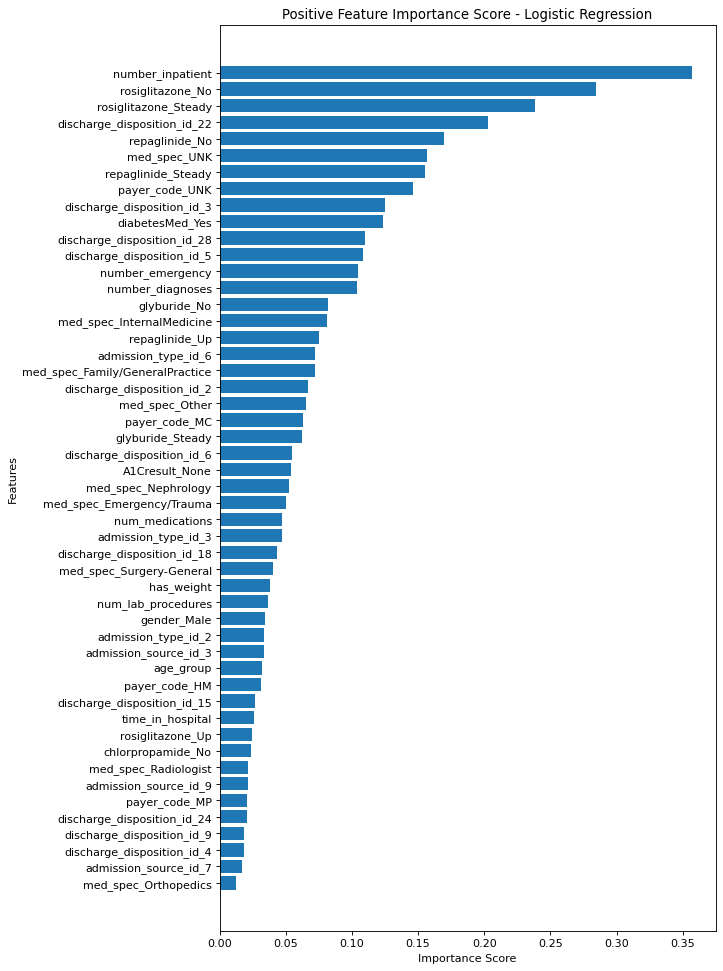

In [219]:
num = 50
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

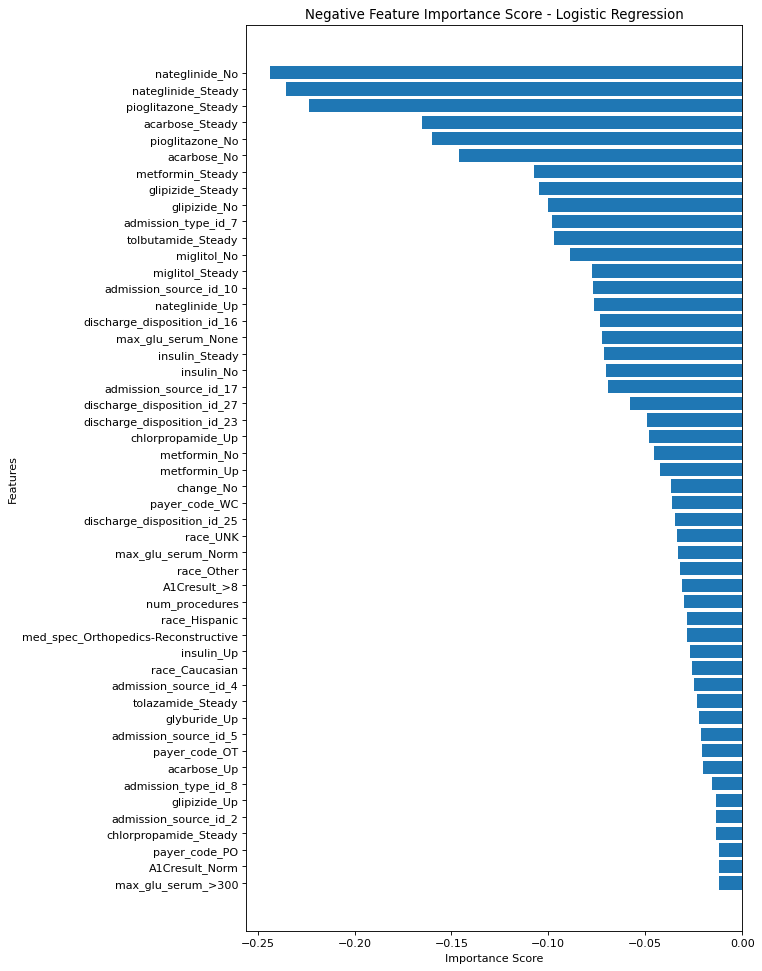

In [220]:
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()


Here we will chose the gradient boosting classifier since it has the best AUC on the validation set.

# Conclusion


Through this project, we created a model to predict the probability that a patient with diabetes would be readmitted to the hospital within 30 days. Our best model had an AUC of of 0.67. Using this model, we are able to catch 58% of the readmissions from our model that performs approximately 1.5 times better than randomly selecting patients.